# 04. Model Interpretation and Insights

Este notebook se enfoca en la interpretación del modelo y extracción de insights de negocio.

## Contenido:
1. Cargar mejor modelo y predicciones
2. Feature Importance (múltiples métodos)
3. SHAP Values para interpretabilidad
4. Partial Dependence Plots
5. Análisis de errores
6. Calibración de probabilidades
7. Business Insights
8. Recomendaciones

## 1. Imports y Configuración

## 2. Definir Transformadores Personalizados

Necesitamos redefinir las clases antes de cargar el pipeline

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class RareGrouper(BaseEstimator, TransformerMixin):
    """
    Agrupa categorías raras en 'OTHER'.
    
    Parameters:
    -----------
    min_pct : float
        Umbral de frecuencia mínima (default: 0.01 = 1%)
        Categorías con frecuencia menor a este valor se agrupan.
    
    Example:
    --------
    >>> rg = RareGrouper(min_pct=0.05)  # Agrupar categorías con < 5%
    >>> rg.fit_transform(df[['categorical_col']])
    """
    def __init__(self, min_pct=0.01):
        self.min_pct = min_pct
        self.mappings = {}
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X.columns:
            freq = X[col].value_counts(normalize=True)
            rare = freq[freq < self.min_pct].index.tolist()
            self.mappings[col] = set(rare)
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col, rare_set in self.mappings.items():
            X[col] = X[col].where(~X[col].isin(rare_set), 'OTHER')
        return X


class FeatureCreator(BaseEstimator, TransformerMixin):
    """
    Crea features derivadas para el modelo de riesgo crediticio.
    
    Features creadas:
    ----------------
    1. is_emp_length_missing: Flag binario para missing values en employment length
    2. is_loan_int_rate_missing: Flag binario para missing values en interest rate
    3. log_person_income: Transformación logarítmica del ingreso
    4. log_loan_amnt: Transformación logarítmica del monto del préstamo
    5. income_to_loan: Ratio ingreso/monto del préstamo
    6. cred_hist_ratio: Ratio historial crediticio/edad
    7. age_bucket: Categorización de edad en bins
    8. loan_amt_rate_inter: Interacción monto × tasa de interés
    
    Parameters:
    -----------
    age_bins : list
        Límites de bins para categorizar edad (default: [18, 25, 35, 50, 100])
    """
    def __init__(self, age_bins=[18, 25, 35, 50, 100]):
        self.age_bins = age_bins
        self.income_q01 = None
        self.income_q99 = None
        self.median_loan_rate = None
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        # Guardar estadísticas del training set
        self.income_q01 = X['person_income'].quantile(0.01)
        self.income_q99 = X['person_income'].quantile(0.99)
        self.median_loan_rate = X['loan_int_rate'].median()
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        
        # 1. Flags de missing values
        X['is_emp_length_missing'] = X['person_emp_length'].isnull().astype(int)
        X['is_loan_int_rate_missing'] = X['loan_int_rate'].isnull().astype(int)
        
        # 2. Transformaciones logarítmicas (log1p maneja zeros)
        X['log_person_income'] = np.log1p(X['person_income'].fillna(0))
        X['log_loan_amnt'] = np.log1p(X['loan_amnt'].fillna(0))
        
        # 3. Features de ratio
        X['income_to_loan'] = X['person_income'] / (1 + X['loan_amnt'].fillna(0))
        X['cred_hist_ratio'] = X['cb_person_cred_hist_length'] / (1 + X['person_age'].fillna(0))
        
        # 4. Age buckets (como string para OneHotEncoding posterior)
        X['age_bucket'] = pd.cut(
            X['person_age'].fillna(-1),
            bins=self.age_bins,
            labels=False,
            include_lowest=True
        ).astype('Int64').astype(str)
        
        # 5. Feature de interacción
        X['loan_amt_rate_inter'] = X['loan_amnt'] * X['loan_int_rate'].fillna(self.median_loan_rate)
        
        # 6. Clipping de outliers en income (usando quantiles del train set)
        X['person_income'] = X['person_income'].clip(
            lower=self.income_q01,
            upper=self.income_q99
        )
        
        return X

def binary_mapping(df):
    return pd.DataFrame(df).replace({'Y': 1, 'N': 0}).astype(float)


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ Imports cargados correctamente')
print('\n⚠️  Nota: SHAP requiere instalación separada: pip install shap')

✅ Imports cargados correctamente

⚠️  Nota: SHAP requiere instalación separada: pip install shap


## 3. Cargar Modelo y Datos

In [21]:
# Cargar mejor modelo
best_model = joblib.load('best_model_rf_optimized.pkl')
print("✅ Modelo cargado")

# Cargar métricas
metrics = joblib.load('model_metrics.pkl')
print("✅ Métricas cargadas")

# Cargar predicciones
predictions = joblib.load('test_predictions.pkl')
y_test = predictions['y_test']
y_pred = predictions['y_pred']
y_proba = predictions['y_proba']
print("✅ Predicciones cargadas")

# Cargar datos transformados
data = joblib.load('transformed_data.pkl')
X_train = data['X_train_transformed']
X_test = data['X_test_transformed']
print("✅ Datos transformados cargados")

# Cargar pipeline de features para obtener nombres
feature_pipeline = joblib.load('feature_engineering_pipeline.pkl')
try:
    feature_names = feature_pipeline.named_steps['preprocessing'].get_feature_names_out()
    print(f"\n📊 Features disponibles: {len(feature_names)}")
except:
    feature_names = None
    print("\n⚠️  No se pudieron obtener nombres de features")

print(f"\n🎯 Performance del modelo:")
print(f"  ROC-AUC: {metrics['test_roc_auc']:.4f}")
print(f"  F1 Score: {metrics['test_f1']:.4f}")

✅ Modelo cargado
✅ Métricas cargadas
✅ Predicciones cargadas
✅ Datos transformados cargados

⚠️  No se pudieron obtener nombres de features

🎯 Performance del modelo:
  ROC-AUC: 0.9396
  F1 Score: 0.8311


## 3. Feature Importance

### 3.1 Feature Importance del Random Forest (Impurity-based)

In [22]:
# Obtener importancias del Random Forest
rf_importances = best_model.feature_importances_

if feature_names is not None:
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_importances
    }).sort_values('importance', ascending=False)
    
    # Top 20 features
    top_20 = importance_df.head(20)
    
    print("\n📊 Top 20 Features Más Importantes (Impurity-based):")
    print(top_20.to_string(index=False))
    
    # Visualización
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_20)), top_20['importance'], color='#3498db', alpha=0.8)
    plt.yticks(range(len(top_20)), top_20['feature'], fontsize=10)
    plt.xlabel('Importancia', fontsize=12)
    plt.title('Top 20 Features Más Importantes (Random Forest)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  Nombres de features no disponibles")
    importance_df = pd.DataFrame({
        'feature_index': range(len(rf_importances)),
        'importance': rf_importances
    }).sort_values('importance', ascending=False)


⚠️  Nombres de features no disponibles


### 3.2 Permutation Importance

Mide la importancia permutando cada feature y observando la degradación del performance

In [23]:
print("🔄 Calculando Permutation Importance...")
print("  (Esto puede tomar varios minutos)\n")

# Calcular permutation importance en test set
perm_importance = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

if feature_names is not None:
    perm_df = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)
    
    # Top 20
    top_20_perm = perm_df.head(20)
    
    print("\n📊 Top 20 Features Más Importantes (Permutation):")
    print(top_20_perm.to_string(index=False))
    
    # Visualización con error bars
    plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(top_20_perm))
    plt.barh(y_pos, top_20_perm['importance_mean'], 
             xerr=top_20_perm['importance_std'],
             color='#e74c3c', alpha=0.8, capsize=3)
    plt.yticks(y_pos, top_20_perm['feature'], fontsize=10)
    plt.xlabel('Importancia (disminución en ROC-AUC)', fontsize=12)
    plt.title('Top 20 Features Más Importantes (Permutation)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  Nombres de features no disponibles")

🔄 Calculando Permutation Importance...
  (Esto puede tomar varios minutos)



KeyboardInterrupt: 

## 4. SHAP Values

SHAP (SHapley Additive exPlanations) proporciona interpretabilidad basada en la teoría de juegos

In [ ]:
try:
    import shap
    
    print("🔍 Calculando SHAP values...")
    print("  (Esto puede tomar varios minutos)\n")
    
    # Usar TreeExplainer para Random Forest (mucho más rápido)
    explainer = shap.TreeExplainer(best_model)
    
    # Calcular SHAP values en una muestra del test set (para velocidad)
    sample_size = min(1000, X_test.shape[0])
    X_test_sample = X_test[:sample_size]
    
    shap_values = explainer.shap_values(X_test_sample)
    
    # Si es clasificación binaria, tomar valores para clase positiva
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    print("✅ SHAP values calculados")
    print(f"  Muestra analizada: {sample_size} observaciones")
    
except ImportError:
    print("\n⚠️  SHAP no está instalado")
    print("  Instalar con: pip install shap")
    shap_values = None
    explainer = None


⚠️  SHAP no está instalado
  Instalar con: pip install shap


In [ ]:
if shap_values is not None:
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, 
                     feature_names=feature_names,
                     show=False,
                     max_display=20)
    plt.title('SHAP Summary Plot - Top 20 Features', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Interpretación del SHAP Summary Plot:")
    print("  • Eje X: Impacto en la predicción (SHAP value)")
    print("  • Color: Valor de la feature (rojo=alto, azul=bajo)")
    print("  • Posición: Cada punto es una observación")
else:
    print("\n⚠️  SHAP values no disponibles")


⚠️  SHAP values no disponibles


In [ ]:
if shap_values is not None:
    # Bar plot de importancia promedio absoluta
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample,
                     feature_names=feature_names,
                     plot_type='bar',
                     show=False,
                     max_display=20)
    plt.title('SHAP Feature Importance - Promedio de Impacto Absoluto', 
             fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

### 4.1 Ejemplos Individuales con SHAP

In [ ]:
if shap_values is not None and explainer is not None:
    # Seleccionar casos interesantes
    y_test_sample = y_test[:sample_size].reset_index(drop=True)
    y_proba_sample = y_proba[:sample_size]
    
    # 1. Un caso de default correctamente predicho (TP)
    tp_idx = np.where((y_test_sample == 1) & (y_proba_sample > 0.5))[0]
    if len(tp_idx) > 0:
        idx = tp_idx[0]
        print(f"\n📈 Caso 1: DEFAULT correctamente predicho (True Positive)")
        print(f"  Índice: {idx}")
        print(f"  Real: Default (1)")
        print(f"  Predicho: {y_proba_sample[idx]:.2%} probabilidad de default")
        
        shap.waterfall_plot(
            shap.Explanation(values=shap_values[idx],
                           base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
                           data=X_test_sample[idx],
                           feature_names=feature_names),
            show=True,
            max_display=15
        )
    
    # 2. Un caso de no-default correctamente predicho (TN)
    tn_idx = np.where((y_test_sample == 0) & (y_proba_sample < 0.5))[0]
    if len(tn_idx) > 0:
        idx = tn_idx[0]
        print(f"\n📉 Caso 2: NO DEFAULT correctamente predicho (True Negative)")
        print(f"  Índice: {idx}")
        print(f"  Real: No Default (0)")
        print(f"  Predicho: {y_proba_sample[idx]:.2%} probabilidad de default")
        
        shap.waterfall_plot(
            shap.Explanation(values=shap_values[idx],
                           base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
                           data=X_test_sample[idx],
                           feature_names=feature_names),
            show=True,
            max_display=15
        )
else:
    print("\n⚠️  SHAP waterfall plots no disponibles")


⚠️  SHAP waterfall plots no disponibles


## 5. Partial Dependence Plots

Muestran la relación marginal entre una feature y la predicción

🔍 Generando Partial Dependence Plots...



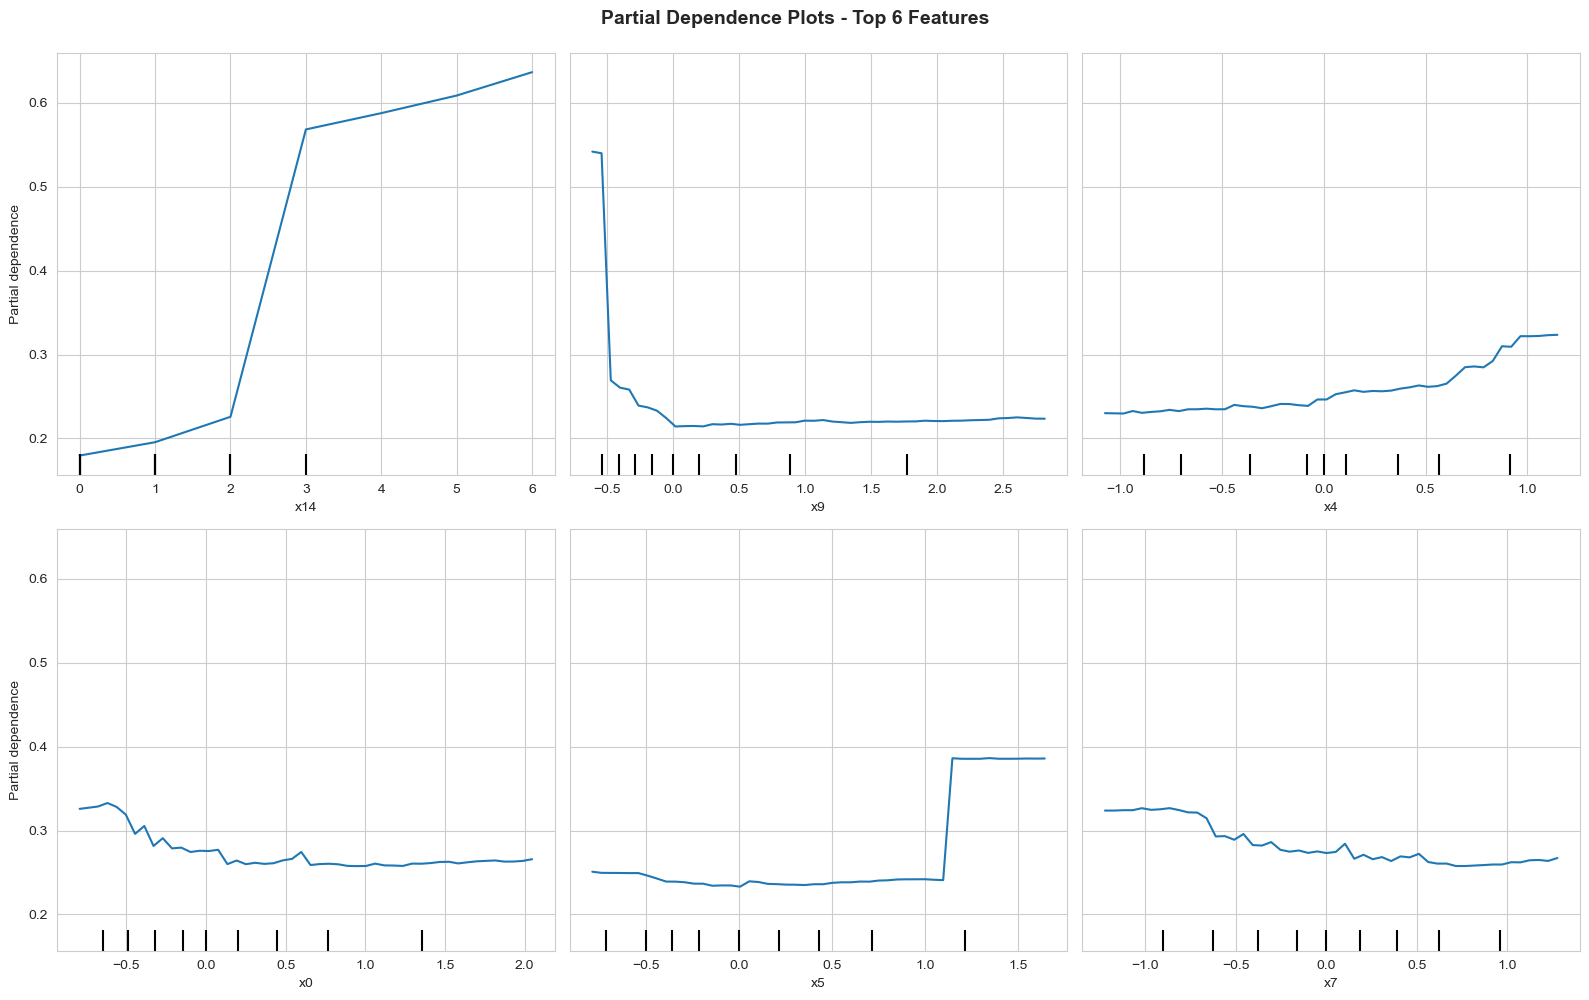


💡 Interpretación:
  • Eje X: Valor de la feature
  • Eje Y: Predicción promedio (controlando otras features)
  • Muestra cómo cambia la predicción al variar solo esa feature


In [ ]:
if importance_df is not None and len(importance_df) > 0:
    # Seleccionar top features para PDP
    top_features_indices = importance_df.head(6).index.tolist()
    
    print("🔍 Generando Partial Dependence Plots...\n")
    
    # Crear PDPs
    fig, ax = plt.subplots(2, 3, figsize=(16, 10))
    
    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X_train,
        features=top_features_indices,
        feature_names=feature_names,
        n_cols=3,
        grid_resolution=50,
        ax=ax
    )
    
    plt.suptitle('Partial Dependence Plots - Top 6 Features', 
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Interpretación:")
    print("  • Eje X: Valor de la feature")
    print("  • Eje Y: Predicción promedio (controlando otras features)")
    print("  • Muestra cómo cambia la predicción al variar solo esa feature")
else:
    print("\n⚠️  No se pueden generar PDPs sin feature importance")

## 6. Análisis de Errores

### 6.1 Análisis de Falsos Positivos y Falsos Negativos

In [ ]:
# Identificar tipos de errores
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Crear DataFrame con resultados
error_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'y_proba': y_proba
})

error_df['error_type'] = 'Correcto'
error_df.loc[(error_df['y_true'] == 0) & (error_df['y_pred'] == 1), 'error_type'] = 'Falso Positivo'
error_df.loc[(error_df['y_true'] == 1) & (error_df['y_pred'] == 0), 'error_type'] = 'Falso Negativo'

print("\n📊 Análisis de Errores:")
print("\nDistribución de resultados:")
print(error_df['error_type'].value_counts())

print(f"\n💰 Análisis de Negocio (costos relativos):")
print(f"  • Falsos Negativos (FN): {fn:,} casos")
print(f"    → Prestamos otorgados a personas que defaultearán")
print(f"    → ALTO COSTO: Pérdida del capital prestado")
print(f"\n  • Falsos Positivos (FP): {fp:,} casos")
print(f"    → Préstamos rechazados a personas que pagarían")
print(f"    → COSTO MEDIO: Pérdida de oportunidad de negocio")


📊 Análisis de Errores:

Distribución de resultados:
error_type
Correcto          6097
Falso Negativo     389
Falso Positivo      31
Name: count, dtype: int64

💰 Análisis de Negocio (costos relativos):
  • Falsos Negativos (FN): 389 casos
    → Prestamos otorgados a personas que defaultearán
    → ALTO COSTO: Pérdida del capital prestado

  • Falsos Positivos (FP): 31 casos
    → Préstamos rechazados a personas que pagarían
    → COSTO MEDIO: Pérdida de oportunidad de negocio


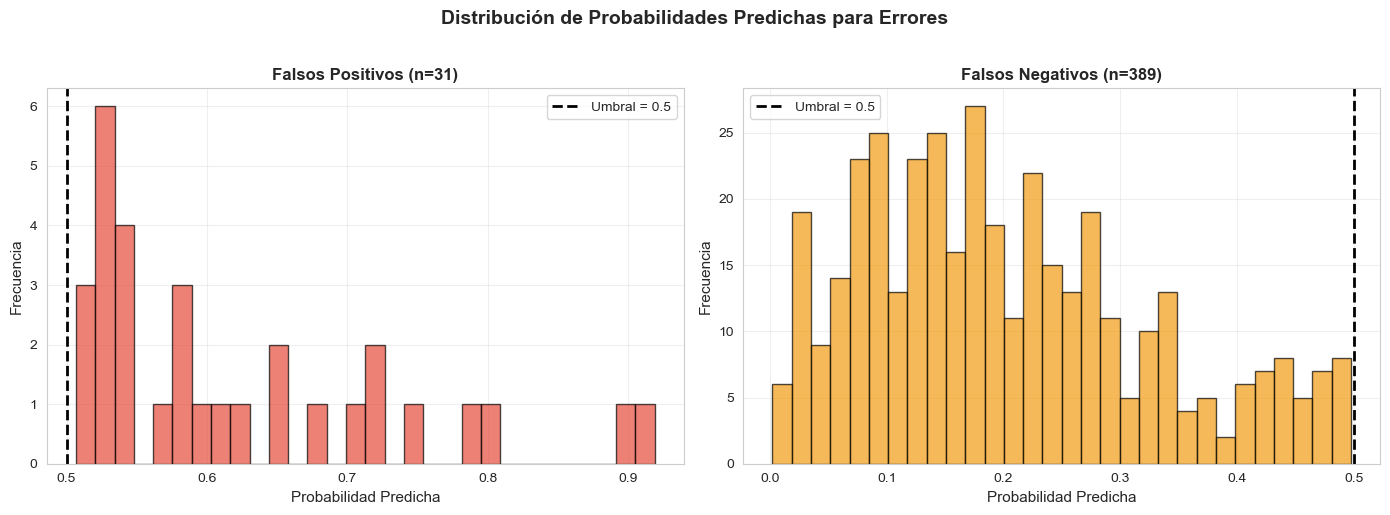


💡 Observaciones:
  • FP promedio proba: 62.17%
  • FN promedio proba: 20.24%
  • FN cercanos al umbral (0.4-0.5): 39


In [ ]:
# Distribución de probabilidades por tipo de error
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Falsos Positivos
fp_proba = error_df[error_df['error_type'] == 'Falso Positivo']['y_proba']
axes[0].hist(fp_proba, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Umbral = 0.5')
axes[0].set_xlabel('Probabilidad Predicha', fontsize=11)
axes[0].set_ylabel('Frecuencia', fontsize=11)
axes[0].set_title(f'Falsos Positivos (n={len(fp_proba)})', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Falsos Negativos
fn_proba = error_df[error_df['error_type'] == 'Falso Negativo']['y_proba']
axes[1].hist(fn_proba, bins=30, color='#f39c12', alpha=0.7, edgecolor='black')
axes[1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Umbral = 0.5')
axes[1].set_xlabel('Probabilidad Predicha', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].set_title(f'Falsos Negativos (n={len(fn_proba)})', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle('Distribución de Probabilidades Predichas para Errores', 
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Observaciones:")
print(f"  • FP promedio proba: {fp_proba.mean():.2%}")
print(f"  • FN promedio proba: {fn_proba.mean():.2%}")
print(f"  • FN cercanos al umbral (0.4-0.5): {((fn_proba >= 0.4) & (fn_proba < 0.5)).sum()}")

### 6.2 Optimización del Umbral de Decisión


🎯 Análisis de Umbrales:
  Umbral actual: 0.5
  F1 Score con umbral 0.5: 0.8311

  Mejor umbral (máximo F1): 0.4429
  F1 Score con mejor umbral: 0.8378
  Mejora: 0.67%


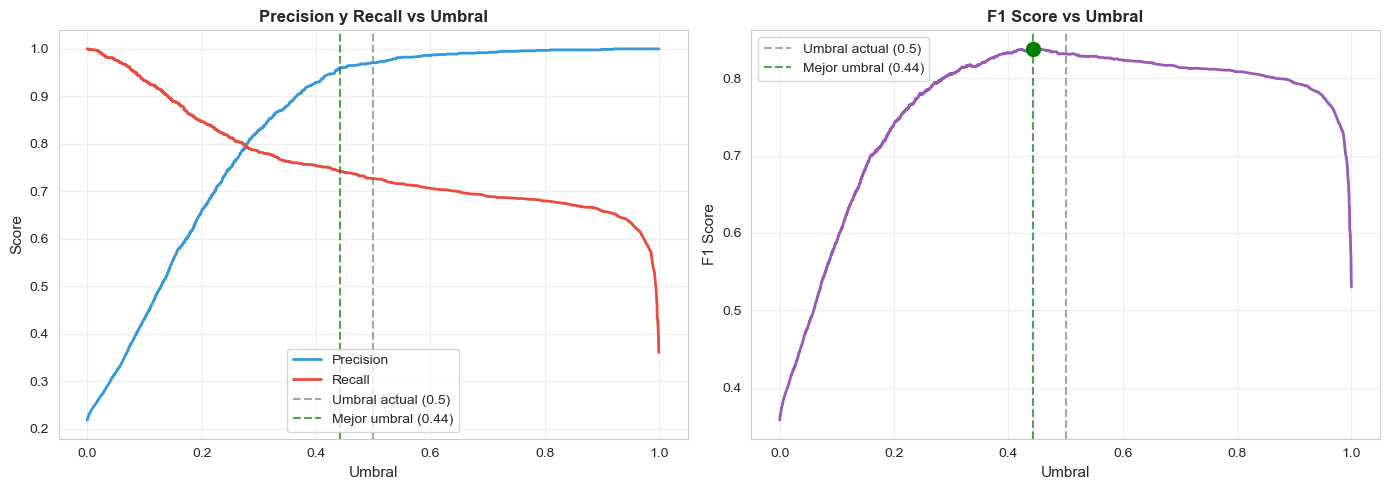

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

# Calcular precision, recall y F1 para diferentes umbrales
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)

# Encontrar mejor umbral por F1
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"\n🎯 Análisis de Umbrales:")
print(f"  Umbral actual: 0.5")
print(f"  F1 Score con umbral 0.5: {f1_score(y_test, y_pred):.4f}")
print(f"\n  Mejor umbral (máximo F1): {best_threshold:.4f}")
print(f"  F1 Score con mejor umbral: {best_f1:.4f}")
print(f"  Mejora: {(best_f1 - f1_score(y_test, y_pred)) * 100:.2f}%")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Precision-Recall vs Threshold
axes[0].plot(thresholds, precisions[:-1], label='Precision', linewidth=2, color='#3498db')
axes[0].plot(thresholds, recalls[:-1], label='Recall', linewidth=2, color='#e74c3c')
axes[0].axvline(0.5, color='gray', linestyle='--', label='Umbral actual (0.5)', alpha=0.7)
axes[0].axvline(best_threshold, color='green', linestyle='--', 
               label=f'Mejor umbral ({best_threshold:.2f})', alpha=0.7)
axes[0].set_xlabel('Umbral', fontsize=11)
axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('Precision y Recall vs Umbral', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# F1 Score vs Threshold
axes[1].plot(thresholds, f1_scores, linewidth=2, color='#9b59b6')
axes[1].axvline(0.5, color='gray', linestyle='--', label='Umbral actual (0.5)', alpha=0.7)
axes[1].axvline(best_threshold, color='green', linestyle='--',
               label=f'Mejor umbral ({best_threshold:.2f})', alpha=0.7)
axes[1].scatter([best_threshold], [best_f1], color='green', s=100, zorder=5)
axes[1].set_xlabel('Umbral', fontsize=11)
axes[1].set_ylabel('F1 Score', fontsize=11)
axes[1].set_title('F1 Score vs Umbral', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Calibración de Probabilidades

Verifica si las probabilidades predichas están bien calibradas

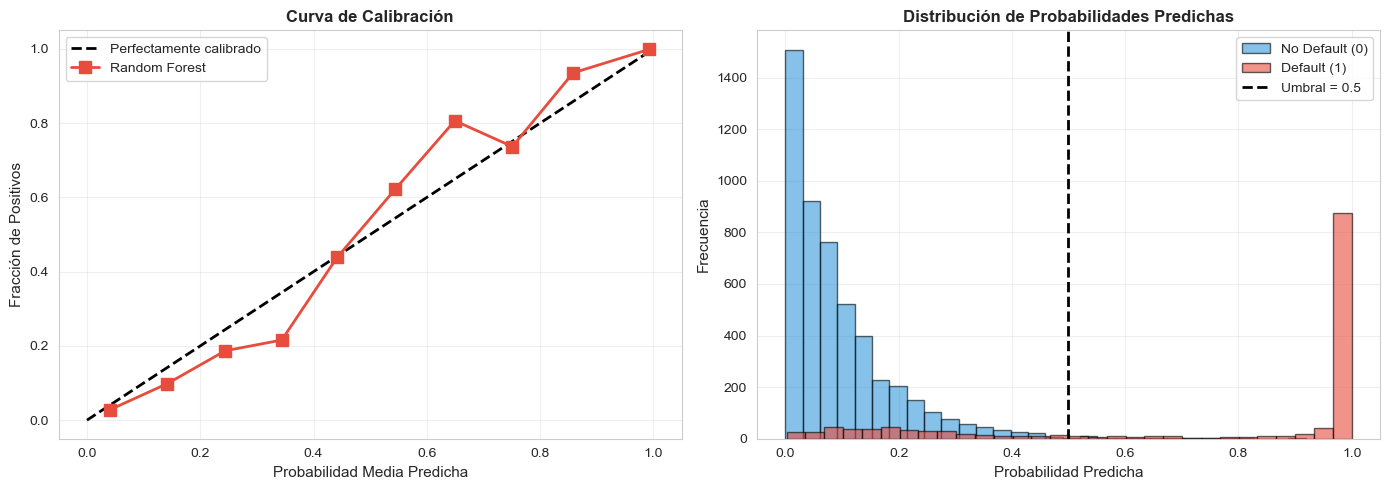


💡 Interpretación de la calibración:
  • Curva cerca de la diagonal = Buena calibración
  • Por encima = Modelo subestima probabilidades
  • Por debajo = Modelo sobreestima probabilidades


In [ ]:
# Curva de calibración
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy='uniform')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calibration curve
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectamente calibrado', linewidth=2)
axes[0].plot(prob_pred, prob_true, 's-', linewidth=2, markersize=8, 
            color='#e74c3c', label='Random Forest')
axes[0].set_xlabel('Probabilidad Media Predicha', fontsize=11)
axes[0].set_ylabel('Fracción de Positivos', fontsize=11)
axes[0].set_title('Curva de Calibración', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distribución de probabilidades
axes[1].hist(y_proba[y_test == 0], bins=30, alpha=0.6, label='No Default (0)', 
            color='#3498db', edgecolor='black')
axes[1].hist(y_proba[y_test == 1], bins=30, alpha=0.6, label='Default (1)',
            color='#e74c3c', edgecolor='black')
axes[1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Umbral = 0.5')
axes[1].set_xlabel('Probabilidad Predicha', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].set_title('Distribución de Probabilidades Predichas', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretación de la calibración:")
print("  • Curva cerca de la diagonal = Buena calibración")
print("  • Por encima = Modelo subestima probabilidades")
print("  • Por debajo = Modelo sobreestima probabilidades")

## 8. Business Insights y Recomendaciones

In [ ]:
print("\n" + "="*70)
print("BUSINESS INSIGHTS Y RECOMENDACIONES")
print("="*70)

print("\n📊 PERFORMANCE DEL MODELO:")
print(f"  • ROC-AUC: {metrics['test_roc_auc']:.2%}")
print(f"  • Sensibilidad (Recall): {tp/(tp+fn)*100:.2f}% de defaults detectados")
print(f"  • Especificidad: {tn/(tn+fp)*100:.2f}% de no-defaults correctos")

print("\n💰 ANÁLISIS DE COSTOS:")
print(f"  • Falsos Negativos: {fn:,} préstamos riesgosos aprobados")
print(f"  • Falsos Positivos: {fp:,} oportunidades de negocio perdidas")

if importance_df is not None:
    print("\n🔑 FACTORES CLAVE DE RIESGO (Top 5):")
    for idx, row in importance_df.head(5).iterrows():
        print(f"  {idx+1}. {row['feature']} (importancia: {row['importance']:.4f})")

print("\n📈 RECOMENDACIONES:")
print("\n1. AJUSTE DE UMBRAL:")
print(f"   • Considerar umbral de {best_threshold:.2f} en lugar de 0.5")
print(f"   • Mejora esperada en F1: {(best_f1 - f1_score(y_test, y_pred)) * 100:.2f}%")

print("\n2. SEGMENTACIÓN DE RIESGO:")
print("   • Alto riesgo: probabilidad > 0.7")
print("   • Riesgo medio: probabilidad 0.3 - 0.7")
print("   • Bajo riesgo: probabilidad < 0.3")

print("\n3. POLÍTICAS DE APROBACIÓN:")
print("   • Rechazo automático: probabilidad > 0.7")
print("   • Revisión manual: probabilidad 0.4 - 0.7")
print("   • Aprobación rápida: probabilidad < 0.4")

print("\n4. MONITOREO CONTINUO:")
print("   • Reentrenar modelo cada 3-6 meses")
print("   • Monitorear drift en distribución de features")
print("   • Validar performance en datos nuevos")

print("\n5. MEJORAS FUTURAS:")
print("   • Incorporar más features externas (bureau data)")
print("   • Explorar modelos más complejos (XGBoost, LightGBM)")
print("   • Implementar calibración de probabilidades")
print("   • Desarrollar sistema de score crediticio")


BUSINESS INSIGHTS Y RECOMENDACIONES

📊 PERFORMANCE DEL MODELO:
  • ROC-AUC: 93.96%
  • Sensibilidad (Recall): 72.64% de defaults detectados
  • Especificidad: 99.39% de no-defaults correctos

💰 ANÁLISIS DE COSTOS:
  • Falsos Negativos: 389 préstamos riesgosos aprobados
  • Falsos Positivos: 31 oportunidades de negocio perdidas

🔑 FACTORES CLAVE DE RIESGO (Top 5):


KeyError: 'feature'

## 9. Exportar Reportes

In [ ]:
# Guardar análisis de errores
error_analysis = {
    'confusion_matrix': cm,
    'error_distribution': error_df['error_type'].value_counts().to_dict(),
    'best_threshold': best_threshold,
    'best_f1': best_f1,
    'fp_mean_proba': fp_proba.mean() if len(fp_proba) > 0 else 0,
    'fn_mean_proba': fn_proba.mean() if len(fn_proba) > 0 else 0
}

joblib.dump(error_analysis, 'error_analysis.pkl')
print("✅ Análisis de errores guardado como 'error_analysis.pkl'")

# Guardar feature importance
if importance_df is not None:
    importance_df.to_csv('feature_importance.csv', index=False)
    print("✅ Feature importance guardado como 'feature_importance.csv'")

# Guardar SHAP values si están disponibles
if shap_values is not None:
    shap_data = {
        'shap_values': shap_values,
        'X_sample': X_test_sample,
        'feature_names': feature_names
    }
    joblib.dump(shap_data, 'shap_analysis.pkl')
    print("✅ SHAP analysis guardado como 'shap_analysis.pkl'")

print("\n" + "="*70)
print("🎉 MODEL INTERPRETATION AND INSIGHTS COMPLETADO")
print("="*70)
print("\nArchivos generados:")
print("  1. error_analysis.pkl")
print("  2. feature_importance.csv")
if shap_values is not None:
    print("  3. shap_analysis.pkl")
print("\n✅ Análisis completo del proyecto Credit Risk Modeling finalizado")